# 基于三维谱神经算子的纳维斯托克斯方程求解

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.5.0/mindflow/zh_cn/data_driven/mindspore_navier_stokes_SNO3D.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.5.0/mindflow/zh_cn/data_driven/mindspore_navier_stokes_SNO3D.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/r2.5.0/docs/mindflow/docs/source_zh_cn/data_driven/navier_stokes_SNO3D.ipynb)

## 概述

计算流体力学是21世纪流体力学领域的重要技术之一，其通过使用数值方法在计算机中对流体力学的控制方程进行求解，从而实现流动的分析、预测和控制。传统的有限元法（finite element method，FEM）和有限差分法（finite difference method，FDM）常用于复杂的仿真流程（物理建模、网格划分、数值离散、迭代求解等）和较高的计算成本，往往效率低下。因此，借助AI提升流体仿真效率是十分必要的。

近年来，随着神经网络的迅猛发展，为科学计算提供了新的范式。经典的神经网络是在有限维度的空间进行映射，只能学习与特定离散化相关的解。与经典神经网络不同，傅里叶神经算子（Fourier Neural Operator，FNO）是一种能够学习无限维函数空间映射的新型深度学习架构。该架构可直接学习从任意函数参数到解的映射，用于解决一类偏微分方程的求解问题，具有更强的泛化能力。更多信息可参考[Fourier Neural Operator for Parametric Partial Differential Equations](https://arxiv.org/abs/2010.08895)。

谱神经算子（Spectral Neural Operator，SNO）是利用多项式将计算变换到频谱空间（Chebyshev,Legendre等）的类似FNO的架构。与FNO相比, SNO的特点是由混淆误差引起的系统偏差较小。其中最重要的好处之一是SNO的基的选择更为宽泛，因此可以在其中找到一组最方便表示的多项式。例如，针对问题的对称性或针对时间间隔来选取适应的基。此外，当输入定义在在非结构化网格上时，基于正交多项式的神经算子相比其他谱算子或更有竞争力。

更多信息可参考, "[Spectral Neural Operators](https://arxiv.org/abs/2205.10573)". arXiv preprint arXiv:2205.10573 (2022).

本教程描述如何使用3D SNO求解Navier-Stokes方程。

## 纳维-斯托克斯方程（Navier-Stokes equation）

纳维-斯托克斯方程（Navier-Stokes equation）是计算流体力学领域的经典方程，是一组描述流体动量守恒的偏微分方程，简称N-S方程。它在二维不可压缩流动中的涡量形式如下：

$$
\partial_t w(x, t)+u(x, t) \cdot \nabla w(x, t)=\nu \Delta w(x, t)+f(x), \quad x \in(0,1)^2, t \in(0, T]
$$

$$
\nabla \cdot u(x, t)=0, \quad x \in(0,1)^2, t \in[0, T]
$$

$$
w(x, 0)=w_0(x), \quad x \in(0,1)^2
$$

其中$u$表示速度场，$w=\nabla \times u$表示涡量，$w_0(x)$表示初始条件，$\nu$表示粘度系数，$f(x)$为外力合力项。


## 问题描述

我们的目标是学习算子将涡量的前10个步骤映射到完整的轨迹[10,T]:

$$ w|_{(0, 1)^2 \times [0, 10]} \mapsto w|_{(0, 1)^2 \times [10, T]} $$

## 技术路径

MindFlow求解该问题的具体流程如下：

1. 创建数据集。
2. 构建模型。
3. 优化器与损失函数。
4. 模型训练。


## Spectral Neural Operator

下图显示了谱神经算子的架构，它由编码器、多层谱卷积层（谱空间的线性变换）和解码器组成。要计算频谱卷积的正向和逆多项式变换矩阵，应在相应的Gauss正交节点（Chebyshev网格等）对输入进行插值。通过卷积编码层将插值后的输入提升到更高维度的通道。其结果将经过多层谱卷积层，每个层对其截断的谱表示应用线性卷积。SNO层的输出通过卷积解码器投影回目标维度，最后插值回原始节点。

SNO层执行以下操作：将多项式变换$A$应用于光谱空间（Chebyshev，Legendre等）操作；多项式低阶模态上的线性卷积$L$操作，高阶模态上的过滤操作；而后，应用逆变换 $S={A}^{-1}$（回到物理空间）。然后添加输入层的线性卷积 $W$操作，并应用非线性激活层。

![SNO网络结构](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/docs/mindflow/docs/source_zh_cn/data_driven/images/SNO.png)

In [1]:
import os
import time
import numpy as np

from mindspore import nn, ops, jit, data_sink, context, Tensor
from mindspore.common import set_seed
from mindspore import dtype as mstype

下述`src`包可以在[applications/data_driven/navier_stokes/sno3d/src](https://gitee.com/mindspore/mindscience/tree/r0.7/MindFlow/applications/data_driven/navier_stokes/sno3d/src)下载。

In [2]:
from mindflow import get_warmup_cosine_annealing_lr, load_yaml_config
from mindflow.utils import print_log
from mindflow.cell import SNO3D, get_poly_transform

from src import calculate_l2_error, UnitGaussianNormalizer, create_training_dataset, load_interp_data, visual

set_seed(0)
np.random.seed(0)

In [3]:
# set context for training: using graph mode for high performance training with GPU acceleration
context.set_context(mode=context.GRAPH_MODE, device_target='GPU', device_id=0)
use_ascend = context.get_context(attr_key='device_target') == "Ascend"
config = load_yaml_config('./configs/sno3d.yaml')
data_params = config["data"]
model_params = config["model"]
optimizer_params = config["optimizer"]
summary_params = config["summary"]

grid_size = data_params["resolution"]
input_timestep = model_params["input_timestep"]
output_timestep = model_params["extrapolations"]


## 创建数据集

训练与测试数据下载: [data_driven/navier_stokes/dataset](https://download.mindspore.cn/mindscience/mindflow/dataset/applications/data_driven/navier_stokes_3d/) .

本案例根据Zongyi Li在 [Fourier Neural Operator for Parametric Partial Differential Equations](https://arxiv.org/pdf/2010.08895.pdf) 一文中对数据集的设置生成训练数据集与测试数据集。具体设置如下：

基于周期性边界，生成满足如下分布的初始条件$w_0(x)$：

$$
w_0 \sim \mu, \mu=\mathcal{N}\left(0,7^{3 / 2}(-\Delta+49 I)^{-2.5}\right)
$$

外力项设置为：

$$
f(x)=0.1\left(\sin \left(2 \pi\left(x_1+x_2\right)\right)+\right.\cos(2 \pi(x_1+x_2)))
$$

采用Crank-Nicolson方法生成数据，时间步长设置为1e-4，最终数据以每 t = 1 个时间单位记录解。所有数据均在256×256的网格上生成，并被下采样至64×64网格。本案例选取粘度系数$\nu=1e−5$，训练集样本量为19000个，测试集样本量为3800个。


In [4]:
load_interp_data(data_params, 'train')
train_loader = create_training_dataset(data_params, shuffle=True)
test_data = load_interp_data(data_params, 'test')
test_a = Tensor(test_data['a'], mstype.float32)
test_u = Tensor(test_data['u'], mstype.float32)

test_u_unif = np.load(os.path.join(data_params['root_dir'], 'test/test_u.npy'))

train_a = Tensor(np.load(os.path.join(
        data_params["root_dir"], "train/train_a_interp.npy")), mstype.float32)
train_u = Tensor(np.load(os.path.join(
        data_params["root_dir"], "train/train_u_interp.npy")), mstype.float32)

train a, u:  (1000, 10, 64, 64) (1000, 40, 64, 64)
test a, u:  (200, 10, 64, 64) (200, 40, 64, 64)


## 构建模型

网络由1个Encoding layer、多个Spectral layer和Decoding block组成:

- 编码卷积在情况下对应`SNO3D.encoder`，将输入数据$x$映射到高维；

- 在这种情况下，SNO层序列对应于`SNO3D.sno_kernel`。使用多项式变换的输入矩阵（三个变量中每个变量的正反转换）来实现时空域和频域之间的转换；

- 解码层对应`SNO3D.decoder`，由两个卷积组成。解码器用于获得最终预测。

In [5]:
n_modes = model_params['modes']
poly_type = data_params['poly_type']
transform_data = get_poly_transform(grid_size, n_modes, poly_type)
transform = Tensor(transform_data["analysis"], mstype.float32)
inv_transform = Tensor(transform_data["synthesis"], mstype.float32)

transform_t_axis = get_poly_transform(output_timestep, n_modes, poly_type)
transform_t = Tensor(transform_t_axis["analysis"], mstype.float32)
inv_transform_t = Tensor(transform_t_axis["synthesis"], mstype.float32)

transforms = [[transform, inv_transform]] * 2 + [[transform_t, inv_transform_t]]

In [6]:
if use_ascend:
    compute_type = mstype.float16
else:
    compute_type = mstype.float32

# prepare model
model = SNO3D(in_channels=model_params['in_channels'],
              out_channels=model_params['out_channels'],
              hidden_channels=model_params['hidden_channels'],
              num_sno_layers=model_params['sno_layers'],
              transforms=transforms,
              kernel_size=model_params['kernel_size'],
              compute_dtype=compute_type)

model_params_list = []
for k, v in model_params.items():
    model_params_list.append(f"{k}-{v}")
model_name = "_".join(model_params_list)

total = 0
for param in model.get_parameters():
    print_log(param.shape)
    total += param.size
print_log(f"Total Parameters:{total}")

(64, 10, 1, 1, 1)
(64, 64, 7, 7, 7)
(64, 64, 1, 1, 1)
(64, 64, 7, 7, 7)
(64, 64, 1, 1, 1)
(64, 64, 7, 7, 7)
(64, 64, 1, 1, 1)
(64, 64, 7, 7, 7)
(64, 64, 1, 1, 1)
(64, 64, 7, 7, 7)
(64, 64, 1, 1, 1)
(64, 64, 1, 1, 1)
(1, 64, 1, 1, 1)
Total Parameters:7049920


## 优化器与损失函数


In [ ]:

lr = get_warmup_cosine_annealing_lr(lr_init=optimizer_params["learning_rate"],
                                    last_epoch=optimizer_params["epochs"],
                                    steps_per_epoch=train_loader.get_dataset_size(),
                                    warmup_epochs=optimizer_params["warmup_epochs"])


steps_per_epoch = train_loader.get_dataset_size()
optimizer = nn.AdamWeightDecay(model.trainable_params(),
                               learning_rate=Tensor(lr),
                               eps=float(optimizer_params['eps']),
                               weight_decay=optimizer_params['weight_decay'])
loss_fn = nn.RMSELoss() #LpLoss()
a_normalizer = UnitGaussianNormalizer(train_a)
u_normalizer = UnitGaussianNormalizer(train_u)

## 训练函数

使用MindSpore>= 2.0.0的版本，可以使用函数式编程范式训练神经网络，单步训练函数使用jit装饰。数据下沉函数data_sink，传入单步训练函数和训练数据集。


In [8]:
def forward_fn(data, label):
    bs = data.shape[0]
    data = a_normalizer.encode(data)
    data = data.reshape(bs, input_timestep, grid_size, grid_size, 1).repeat(output_timestep, axis=-1)
    logits = model(data).reshape(bs, output_timestep, grid_size, grid_size)

    logits = u_normalizer.decode(logits)
    loss = loss_fn(logits.reshape(bs, -1), label.reshape(bs, -1))
    if use_ascend:
        loss = loss_scaler.scale(loss)
    return loss

grad_fn = ops.value_and_grad(
    forward_fn, None, optimizer.parameters, has_aux=False)

from mindspore.amp import DynamicLossScaler, auto_mixed_precision, all_finite
if use_ascend:
    loss_scaler = DynamicLossScaler(1024, 2, 100)
    auto_mixed_precision(model, 'O2')
else:
    loss_scaler = None

@jit
def train_step(data, label):
    loss, grads = grad_fn(data, label)
    if use_ascend:
        loss = loss_scaler.unscale(loss)
        is_finite = all_finite(grads)
        if is_finite:
            grads = loss_scaler.unscale(grads)
            loss = ops.depend(loss, optimizer(grads))
        loss_scaler.adjust(is_finite)
    else:
        loss = ops.depend(loss, optimizer(grads))
    return loss

sink_process = data_sink(train_step, train_loader, sink_size=200)


## 模型训练

使用**MindSpore >= 2.0.0**的版本，可以使用函数式编程范式训练神经网络。

In [11]:
summary_dir = os.path.join(summary_params["root_dir"], model_name)
ckpt_dir = os.path.join(summary_dir, summary_params["ckpt_dir"])
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

In [9]:
def train():
    for epoch in range(1, 1 + optimizer_params["epochs"]):
        local_time_beg = time.time()
        model.set_train(True)
        cur_loss = sink_process()
        local_time_end = time.time()
        epoch_seconds = local_time_end - local_time_beg
        step_seconds = (epoch_seconds/200)
        print_log(
            f"epoch: {epoch} train loss: {cur_loss} epoch time: {epoch_seconds:.3f}s step time: {step_seconds:5.3f}ms")

        if epoch % summary_params['test_interval'] == 0:
            model.set_train(False)
            calculate_l2_error(model, test_a, test_u, data_params, a_normalizer, u_normalizer)

In [11]:
train()

epoch: 1 train loss: 0.90118235 epoch time: 44.718s step time: 0.224s
epoch: 2 train loss: 0.91254395 epoch time: 40.240s step time: 0.201s
epoch: 3 train loss: 0.9374327 epoch time: 40.302s step time: 0.202s
epoch: 4 train loss: 0.85217404 epoch time: 40.482s step time: 0.202s
epoch: 5 train loss: 0.6309165 epoch time: 40.590s step time: 0.203s
epoch: 6 train loss: 0.4290015 epoch time: 40.576s step time: 0.203s
epoch: 7 train loss: 0.34428337 epoch time: 40.536s step time: 0.203s
epoch: 8 train loss: 0.34126174 epoch time: 40.564s step time: 0.203s
epoch: 9 train loss: 0.27420813 epoch time: 40.571s step time: 0.203s
epoch: 10 train loss: 0.2711888 epoch time: 40.554s step time: 0.203s
================================Start Evaluation================================
Error on Gauss grid: 0.28268588, on regular grid: 0.2779018060781111
predict total time: 26.014892578125 s
=================================End Evaluation=================================
epoch: 11 train loss: 0.2603902 ep

In [ ]:
visual(model, test_a, data_params, a_normalizer, u_normalizer)

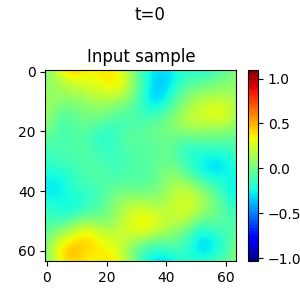

In [13]:
from IPython.display import Image, display
with open('images/input.gif', 'rb') as f:
    display(Image(data=f.read(), format='png', embed=True))

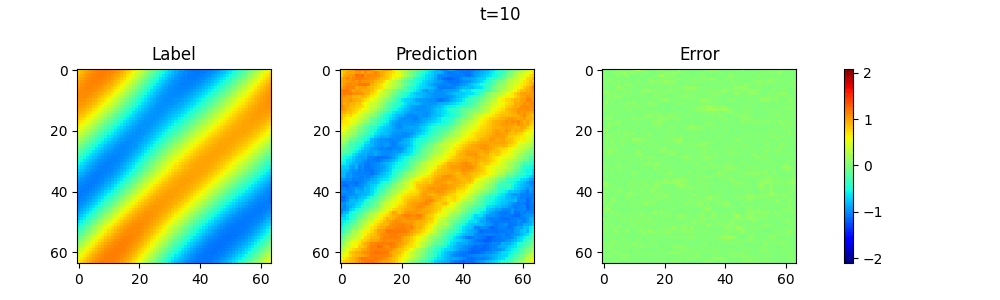

In [4]:
with open('images/result.gif', 'rb') as f:
    display(Image(data=f.read(), format='png', embed=True))